# Tissue Classification

---

In [145]:
import os
import matplotlib.pyplot as plt
import PIL
import random
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
from tqdm.notebook import tqdm

import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.15.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALL

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print gpu name
if torch.cuda.is_available(): 
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device='cuda'))

Using device: cuda
NVIDIA GeForce RTX 3090
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24257MB, multi_processor_count=82, uuid=e7c31494-7e41-d1c4-a803-f28dc77117f5, L2_cache_size=6MB)


Unzip the data

In [3]:
data_path = 'data/'

train_folder = 'NCT-CRC-HE-100K'
test_folder = 'CRC-VAL-HE-7K'

train_zip = data_path + train_folder + ".zip"
test_zip = data_path + test_folder + ".zip"

train_path = data_path + "NCT-CRC-HE-100K"
test_path = data_path + "CRC-VAL-HE-7K"

In [4]:
# Unzip data
import zipfile

# If data is not unzipped
if not os.path.exists(train_path):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Train data unzipped")

if not os.path.exists(test_path):
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Test data unzipped")

Change image format

In [4]:
# Change format from .tif to .jpg
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.tif'):
            img = Image.open(os.path.join(root, file))
            img.save(os.path.join(root, file.replace('.tif', '.jpg')))
            os.remove(os.path.join(root, file))

### Reproducibility

In [6]:
# Random seed
seed = 42

np.random.seed(seed)
random.seed(seed)
set_determinism(seed=seed)

## Train data

In [5]:
class_names = sorted(x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(train_path, class_names[i], x) for x in os.listdir(os.path.join(train_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 100000
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [10407, 10566, 11512, 11557, 8896, 13536, 8763, 10446, 14317]


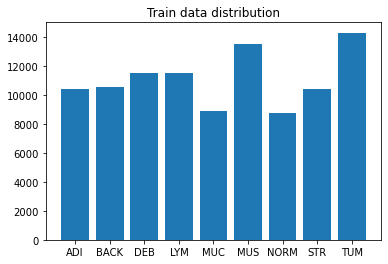

In [6]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Train data distribution")
plt.show()

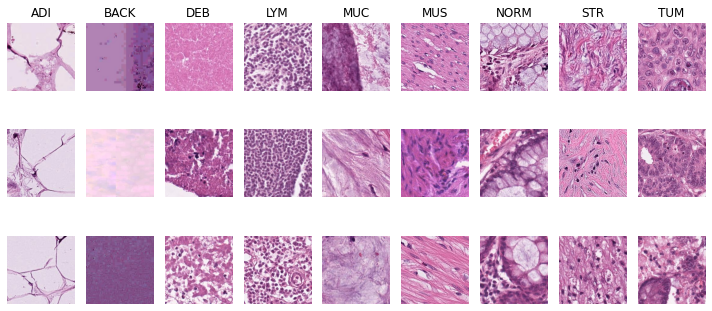

In [7]:
# Plot an image from each class
plt.figure(figsize=(10, 5))
for j in range(3):
    for i in range(num_class):
        plt.subplot(3, num_class, i+1+j*num_class)
        plt.imshow(PIL.Image.open(image_files[i][10*j]))
        if j==0:
            plt.title(class_names[i])
        plt.axis("off")
plt.tight_layout()
plt.show()

## Undersampling: Dataset Balancing

Class with less samples: NORM with 8763 images
---
ADI        Taking 8763 from initial 10407 samples
BACK       Taking 8763 from initial 10566 samples
DEB        Taking 8763 from initial 11512 samples
LYM        Taking 8763 from initial 11557 samples
MUC        Taking 8763 from initial 8896 samples
MUS        Taking 8763 from initial 13536 samples
NORM       Taking 8763 from initial 8763 samples
STR        Taking 8763 from initial 10446 samples
TUM        Taking 8763 from initial 14317 samples
---
Total number of images: 78867


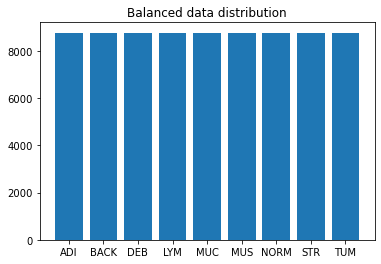

In [8]:
num_min_class = min(num_each)
print(f"Class with less samples: {class_names[np.argmin(num_each)]} with {num_min_class} images")
print("---")
balanced_image_files_list = []
balanced_image_class = []
for i in range(num_class):
    print(f"{class_names[i]:<10} Taking {num_min_class} from initial {len(image_files[i])} samples")
    balanced_image_files_list.extend(random.sample(image_files[i], num_min_class))
    balanced_image_class.extend([i] * num_min_class)

print("---")
print(f"Total number of images: {len(balanced_image_class)}")

# Plot balanced data distribution
plt.figure()
plt.bar(class_names, [balanced_image_class.count(i) for i in range(num_class)])
plt.title("Balanced data distribution")
plt.show()

## Prepare training and validation splits

Training count: 63094, Validation count: 15773


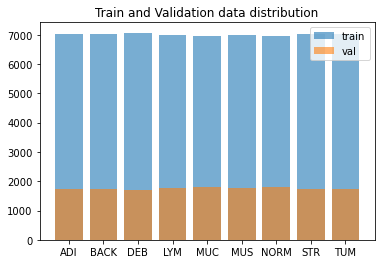

In [9]:
val_frac = 0.2
length = len(balanced_image_files_list)
indices = np.arange(length)
# Set seed for reproducibility
np.random.seed(seed)
np.random.shuffle(indices)

val_split = int(val_frac * length)
val_indices = indices[:val_split]
train_indices = indices[val_split:]

train_x = [balanced_image_files_list[i] for i in train_indices]
train_y = [balanced_image_class[i] for i in train_indices]
val_x = [balanced_image_files_list[i] for i in val_indices]
val_y = [balanced_image_class[i] for i in val_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

# Plot train and validation data distribution
plt.figure()
plt.bar(class_names, [train_y.count(i) for i in range(num_class)], alpha=0.6, label="train")
plt.bar(class_names, [val_y.count(i) for i in range(num_class)], alpha=0.6, label="val")
plt.title("Train and Validation data distribution")
plt.legend()
plt.show()

## Define transforms, Dataset and Dataloader to pre-process data

Preprocess and data augmentation:

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        # Data augmentation:
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

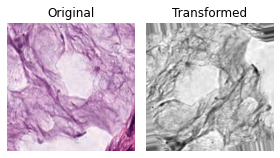

In [11]:
# Example of original and transformed image
plt.figure(figsize=(4, 4))

trans = train_transforms(train_x[1])
orig = PIL.Image.open(train_x[1])

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(trans[0], cmap="gray")
plt.title("Transformed")
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
class TissuesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = TissuesDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=10)
print("Number of train batches:", len(train_loader))

val_ds = TissuesDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=10)
print("Number of validation batches:", len(val_loader))

Number of train batches: 986
Number of validation batches: 247


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
1. Use DenseNet from MONAI and move to GPU device.
1. Use Adam optimizer.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class, pretrained=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

Device: cuda
NVIDIA L40S


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [14]:
models_path = "models/"

In [15]:
TRAINING = False
if TRAINING:
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    
    for epoch in range(max_epochs):
    #    print("-" * 10)
    #    print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=True)
        for batch_data in train_progress:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    #        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
    #    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                val_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=True)
                for val_data in val_progress:
                    val_images, val_labels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(models_path, "best_multilabel_model.pth"))
                print(
                    f"Epoch: {epoch + 1} Validation AUC: {result:.4f}"
                    f" Validation accuracy: {acc_metric:.4f}"
                    f" Best AUC: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
    
    print("---")
    print(f"Training completed")
    print(f"Best validation AUC: {best_metric:.4f} at epoch: {best_metric_epoch}")

## Plot the loss and metric

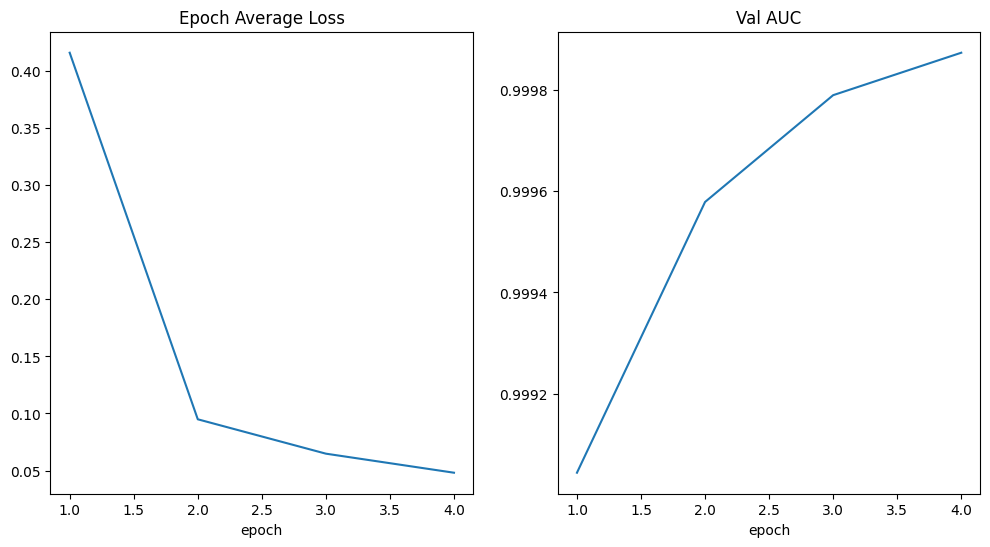

In [25]:
if TRAINING:
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title("Val AUC")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.show()

## Evaluation with test data

In [16]:
class_names = sorted(x for x in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, x)))
num_class = len(class_names)
test_image_files = [
    [os.path.join(test_path, class_names[i], x) for x in os.listdir(os.path.join(test_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(test_image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(test_image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 7180
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [1338, 847, 339, 634, 1035, 592, 741, 421, 1233]


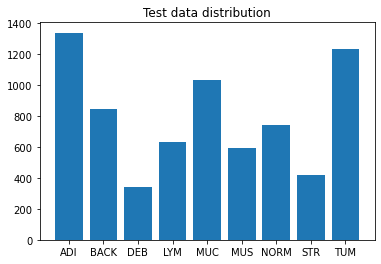

In [17]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Test data distribution")
plt.show()

In [18]:
test_ds = TissuesDataset(image_files_list, image_class, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=10)
print("Number of test batches:", len(test_loader))

Number of test batches: 113


In [19]:
model.load_state_dict(torch.load(os.path.join(models_path, "best_metric_model.pth"), weights_only=True))
model.eval()
print("Model loaded")

y_true = []
y_pred = []
with torch.no_grad():
    test_progress = tqdm(test_loader, desc=f"Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

Model loaded


Test evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         ADI     0.9931    0.9738    0.9834      1338
        BACK     0.9988    0.9941    0.9964       847
         DEB     0.9037    0.9410    0.9220       339
         LYM     0.9950    0.9511    0.9726       634
         MUC     0.9336    0.9923    0.9621      1035
         MUS     0.7786    0.9088    0.8387       592
        NORM     0.9443    0.9838    0.9636       741
         STR     0.9683    0.6532    0.7801       421
         TUM     0.9844    0.9732    0.9788      1233

    accuracy                         0.9521      7180
   macro avg     0.9444    0.9301    0.9331      7180
weighted avg     0.9555    0.9521    0.9513      7180



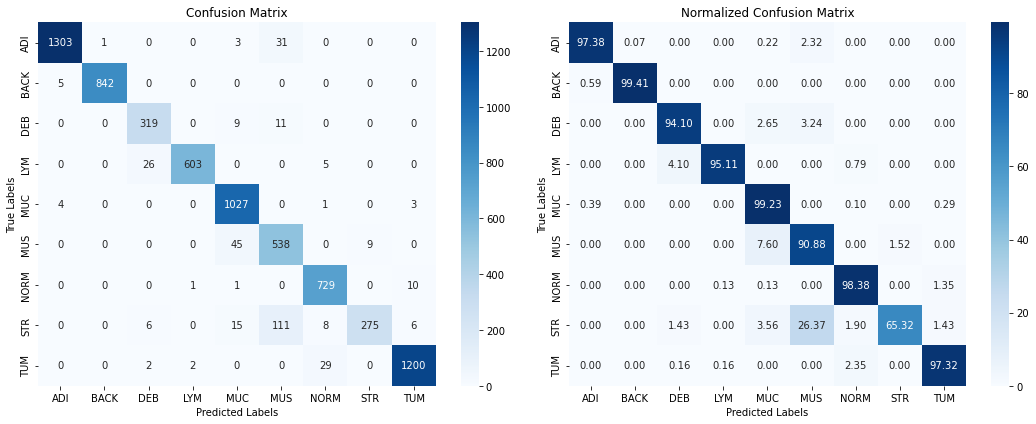

In [21]:
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix and normalized confusion matrix in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Labels")
ax[0].set_ylabel("True Labels")
cm_norm = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100
sns.heatmap(cm_norm, annot=True, cmap="Blues", ax=ax[1], xticklabels=class_names, yticklabels=class_names, fmt=".2f")
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted Labels")
ax[1].set_ylabel("True Labels")
plt.tight_layout()
plt.show()

## ROC Curves and AUC metric

In [144]:
model.load_state_dict(torch.load(os.path.join(models_path, "best_metric_model.pth"), weights_only=True))
model.eval()

y_true = []
y_score = []  

with torch.no_grad():
    test_progress = tqdm(test_loader, desc="Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

        preds = torch.softmax(model(test_images), dim=1)  
        y_true.extend(test_labels.cpu().numpy())
        y_score.extend(preds.cpu().numpy()) 
        
y_true = np.array(y_true)
y_score = np.array(y_score)

# One-hot encode the true labels
num_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

Test evaluation: 100%|████████████████████████| 113/113 [00:06<00:00, 16.77it/s]


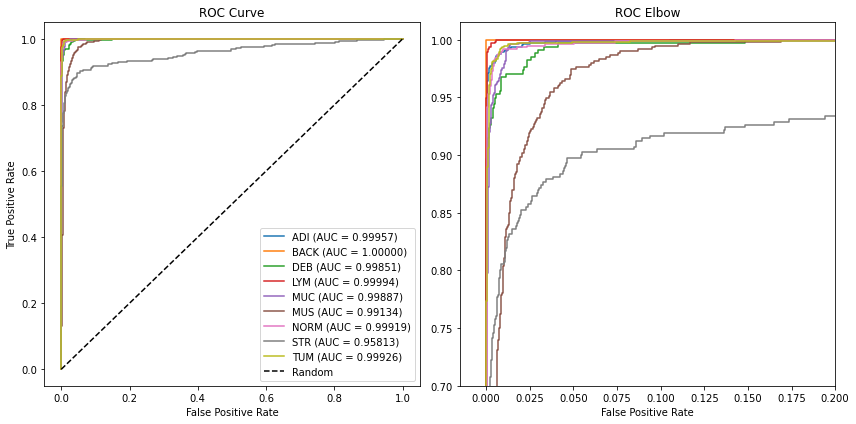

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sens_85_spec = {}
target_fpr = 0.15

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    closest_idx = np.argmin(np.abs(fpr - target_fpr)) 
    sens_85_spec[class_names[i]] = tpr[closest_idx]
    axes[0].plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.5f})')

axes[0].plot([0, 1], [0, 1], 'k--', label="Random")
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")


for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    axes[1].plot(fpr, tpr)

axes[1].set_xlim([-0.015, 0.2])
axes[1].set_ylim([0.7, 1.015])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_title("ROC Elbow")

plt.tight_layout()
plt.show()


### Sensitivity (TPR) for 85% specificity
$1 - \text{FPR} = 0.85 \rightarrow \text{FPR} \approx 0.15$


In [42]:
for class_name, sens in sens_85_spec.items():
    print(f"{class_name:<5} {sens:.5f}")

ADI   0.99925
BACK  0.99646
DEB   0.99705
LYM   0.99842
MUC   0.99903
MUS   0.99831
NORM  0.99865
STR   0.92399
TUM   0.99838


## Old model:
- Unbalanced classes
- Not pretrained
- Smaller batches

In [46]:
model.load_state_dict(torch.load(os.path.join(models_path, "old.pth"), weights_only=True))
model.eval()
print("Model loaded")

y_true = []
y_pred = []
with torch.no_grad():
    test_progress = tqdm(test_loader, desc=f"Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Model loaded


Test evaluation: 100%|████████████████████████| 113/113 [00:12<00:00,  8.75it/s]

              precision    recall  f1-score   support

         ADI     0.9942    0.6450    0.7824      1338
        BACK     0.9139    0.9906    0.9507       847
         DEB     0.7470    0.9322    0.8294       339
         LYM     0.9744    0.8991    0.9352       634
         MUC     0.9745    0.8850    0.9276      1035
         MUS     0.4967    0.7517    0.5981       592
        NORM     0.6883    0.9001    0.7801       741
         STR     0.7530    0.6010    0.6684       421
         TUM     0.9221    0.9311    0.9266      1233

    accuracy                         0.8380      7180
   macro avg     0.8293    0.8373    0.8221      7180
weighted avg     0.8694    0.8380    0.8415      7180



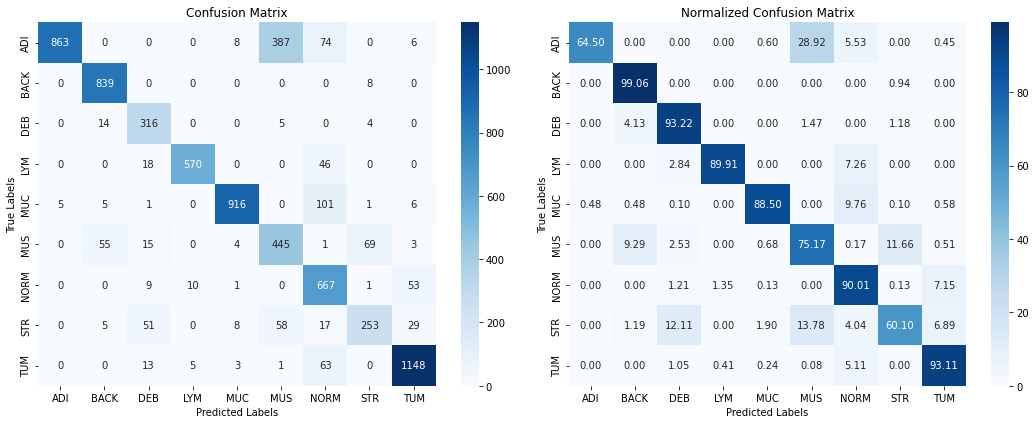

In [47]:
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix and normalized confusion matrix in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Labels")
ax[0].set_ylabel("True Labels")
cm_norm = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100
sns.heatmap(cm_norm, annot=True, cmap="Blues", ax=ax[1], xticklabels=class_names, yticklabels=class_names, fmt=".2f")
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted Labels")
ax[1].set_ylabel("True Labels")
plt.tight_layout()
plt.show()

In [48]:
model.load_state_dict(torch.load(os.path.join(models_path, "old.pth"), weights_only=True))
model.eval()

y_true = []
y_score = []  

with torch.no_grad():
    test_progress = tqdm(test_loader, desc="Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

        preds = torch.softmax(model(test_images), dim=1)  
        y_true.extend(test_labels.cpu().numpy())
        y_score.extend(preds.cpu().numpy()) 
        
y_true = np.array(y_true)
y_score = np.array(y_score)

# One-hot encode the true labels
num_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

Test evaluation: 100%|████████████████████████| 113/113 [00:06<00:00, 16.38it/s]


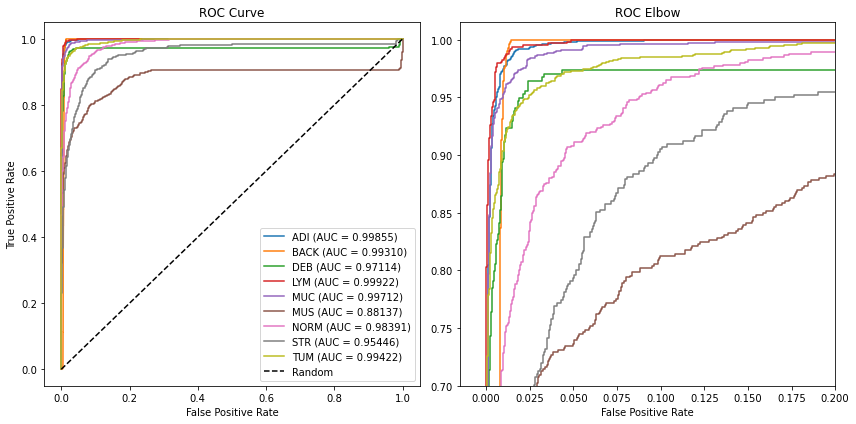

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: Full ROC Curve
sens_85_spec = {}
target_fpr = 0.15

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    closest_idx = np.argmin(np.abs(fpr - target_fpr))  # Índice más cercano
    sens_85_spec[class_names[i]] = tpr[closest_idx]
    axes[0].plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.5f})')

axes[0].plot([0, 1], [0, 1], 'k--', label="Random")
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

# Second subplot: Zoomed-in ROC Elbow
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    axes[1].plot(fpr, tpr)

axes[1].set_xlim([-0.015, 0.2])
axes[1].set_ylim([0.7, 1.015])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_title("ROC Elbow")

plt.tight_layout()
plt.show()


## Activation maps

In [143]:
# Get layer names
# ONLY PRINTING ONE DENSEBLOCK
for name, _ in model.named_modules():
    if any(f"denseblock{i}" in name for i in range(2, 4+1)):
        continue
    print(name)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.norm1
features.denseblock1.denselayer3.layers.relu1
features.denseblock1.denselayer3.layers.conv1


In [136]:
from monai.visualize import CAM, GradCAMpp
from PIL import Image

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class, pretrained=True).to(device)
model.to(device)
model.load_state_dict(torch.load(os.path.join(models_path, "best_metric_model.pth"), weights_only=True))
model.eval()
model_2d = model

# usage reference:
# gradcampp = GradCAMpp(model, target_layers="features.transition1.pool")
# cam = CAM(nn_module=model_2d, target_layers="class_layers.relu", fc_layers="class_layers.out")

In [137]:
def plot_gradcampp(orig_image_path, label):
    layers = [
        "features.transition1",
        "features.transition2",
        "features.transition3",
        "class_layers.relu",
    ]
    
    image = val_transforms(orig_image_path).unsqueeze(0).to(device)
    # Rotate the image 90 degrees
    image = torch.rot90(image, -1, [2, 3])
    # Flip the image horizontally
    image = torch.flip(image, [3])
    
    # Get prediction
    pred = model(image).argmax(dim=1).item()
    print(f"Prediction: {pred} ({class_names[pred]}) | Real Label: {label} ({class_names[label]})")

    # Generate GradCAM++ maps
    cams = [image[0][0].cpu()]  # Store original image
    for layer in layers:
        gradcampp = GradCAMpp(model, target_layers=layer)

        gradcam_map = gradcampp(image, label)
        gradcam_map = gradcam_map[0].cpu().numpy()
        gradcam_map = np.transpose(gradcam_map, (1, 2, 0))
        gradcam_map = np.maximum(gradcam_map, 0)
        gradcam_map = gradcam_map / gradcam_map.max()
        cams.append(gradcam_map)

    # Plot results
    plt.figure(figsize=(12, 6))
    titles = ["Original"] + layers
    for i in range(len(layers)+1):
        plt.subplot(1, len(layers)+1, i + 1)
        if i > 0:
            plt.imshow(cams[0], cmap="gray", alpha=0.5)  # Input image
            plt.imshow(cams[i], cmap="jet", alpha=0.5)  # GradCAM++
        else:
            plt.imshow(PIL.Image.open(orig_image_path))  # Input image
        plt.title(titles[i])  # Show layer name
        plt.axis("off")

    plt.tight_layout()
    plt.show()


### CAM for all classes

Prediction: 0 (ADI) | Real Label: 0 (ADI)


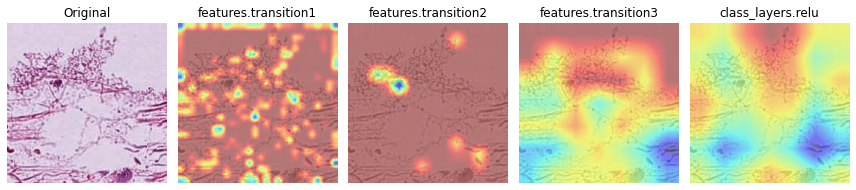

Prediction: 1 (BACK) | Real Label: 1 (BACK)


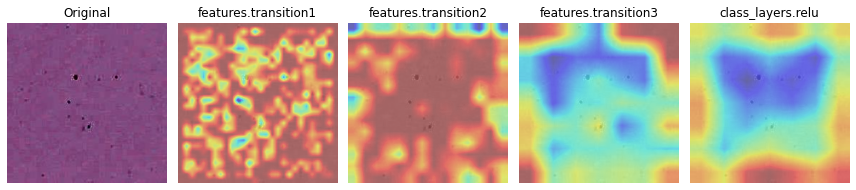

Prediction: 2 (DEB) | Real Label: 2 (DEB)


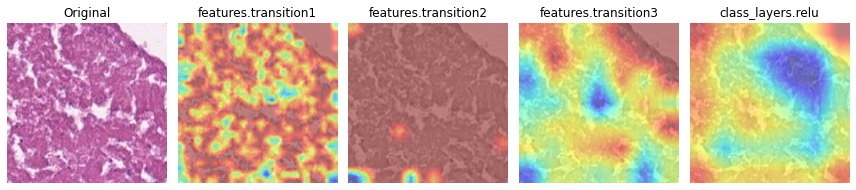

Prediction: 3 (LYM) | Real Label: 3 (LYM)


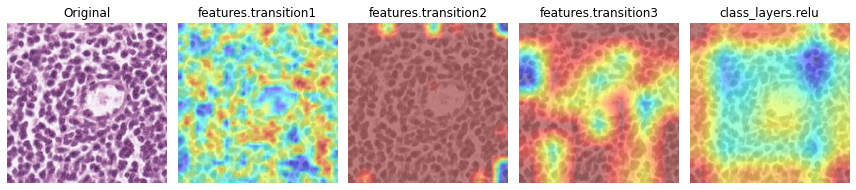

Prediction: 4 (MUC) | Real Label: 4 (MUC)


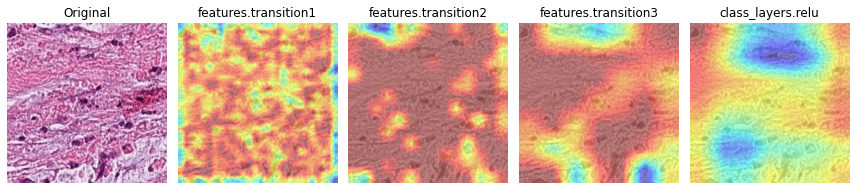

Prediction: 0 (ADI) | Real Label: 5 (MUS)


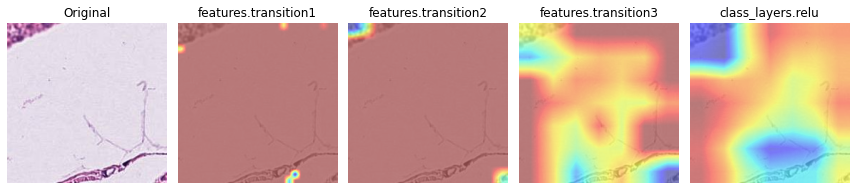

Prediction: 6 (NORM) | Real Label: 6 (NORM)


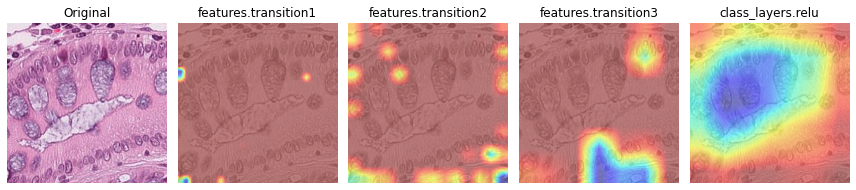

Prediction: 7 (STR) | Real Label: 7 (STR)


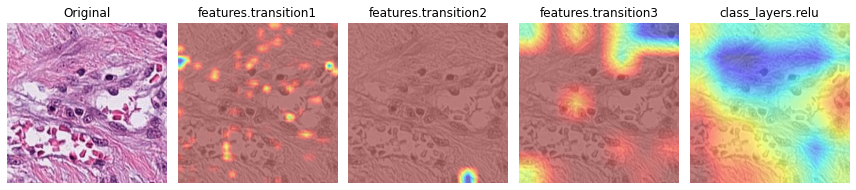

Prediction: 8 (TUM) | Real Label: 8 (TUM)


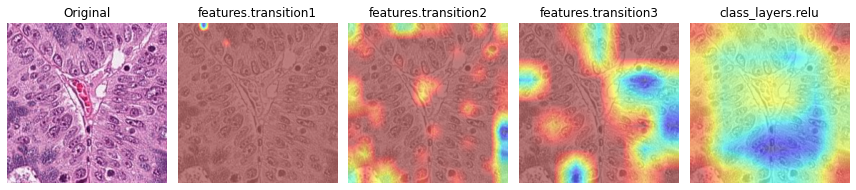

In [138]:
test_img_idx = 2

for i in range(num_class):
    image = image_files[i][test_img_idx]
    label = i

    plot_gradcampp(image, label)

## Model Weakness: Comparison STR vs MUS

### STR True Positives

Prediction: 7 (STR) | Real Label: 7 (STR)


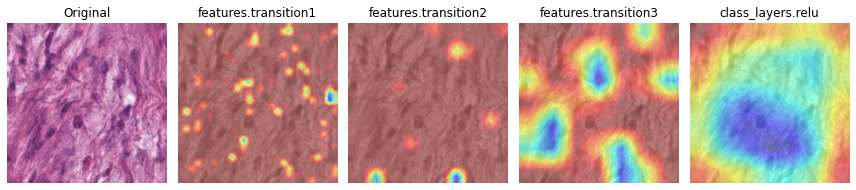

Prediction: 7 (STR) | Real Label: 7 (STR)


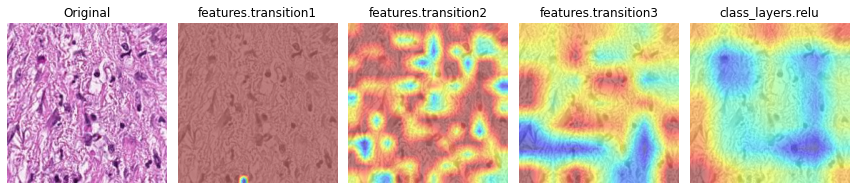

Prediction: 5 (MUS) | Real Label: 7 (STR)


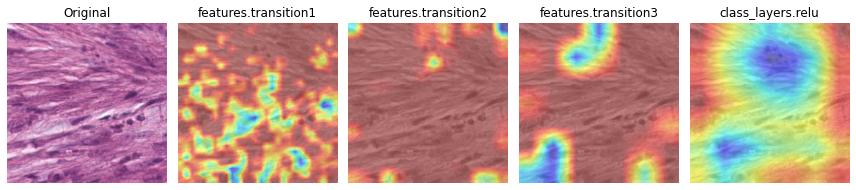

Prediction: 7 (STR) | Real Label: 7 (STR)


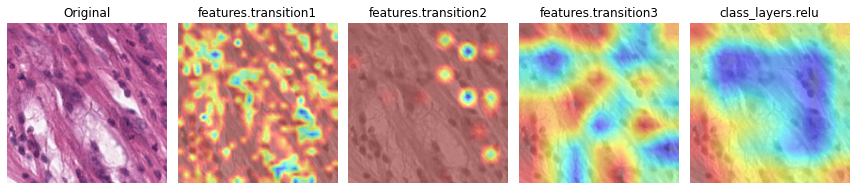

Prediction: 5 (MUS) | Real Label: 7 (STR)


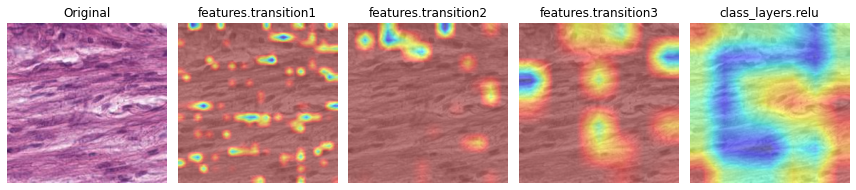

In [139]:
str_label = 7 # MUS

# Get 5 STR predictions
str_preds = []
for i in range(len(y_true)):
    if y_true[i] == str_label and y_pred[i] == str_label:
        str_preds.append(i)
    if len(str_preds) == 5:
        break

# Plot GradCAM++ and CAM for the STR predictions
for i in str_preds:
    image = image_files_list[i]
    label = y_true[i]

    plot_gradcampp(image, label)

### MUS True Positives

Prediction: 5 (MUS) | Real Label: 5 (MUS)


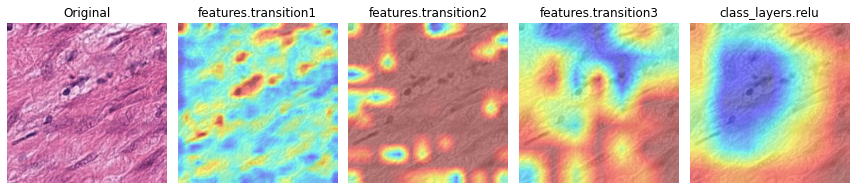

Prediction: 5 (MUS) | Real Label: 5 (MUS)


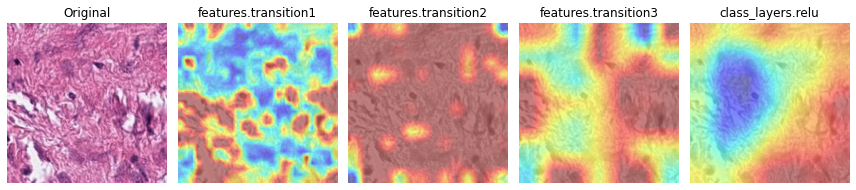

Prediction: 5 (MUS) | Real Label: 5 (MUS)


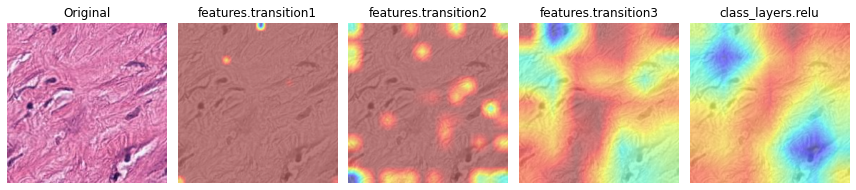

Prediction: 5 (MUS) | Real Label: 5 (MUS)


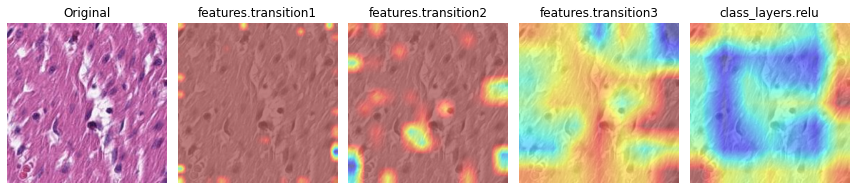

Prediction: 5 (MUS) | Real Label: 5 (MUS)


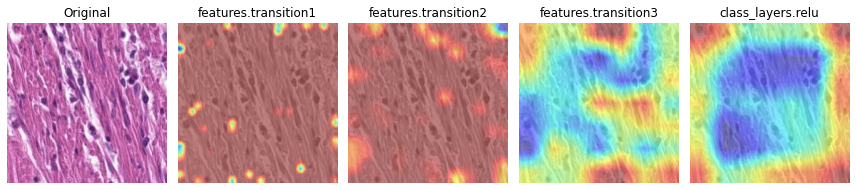

In [141]:
mus_label = 5 # MUS

# Get 5 MUS predictions
mus_preds = []
for i in range(len(y_true)):
    if y_true[i] == mus_label and y_pred[i] == mus_label:
        mus_preds.append(i)
    if len(mus_preds) == 5:
        break

# Plot GradCAM++ and CAM for the MUS predictions
for i in mus_preds:
    image = image_files_list[i]
    label = y_true[i]

    plot_gradcampp(image, label)

### STR False Positives

STR labeled images predicted as MUS.

Prediction: 7 (STR) | Real Label: 7 (STR)


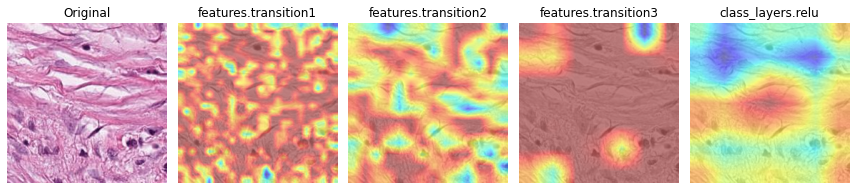

Prediction: 7 (STR) | Real Label: 7 (STR)


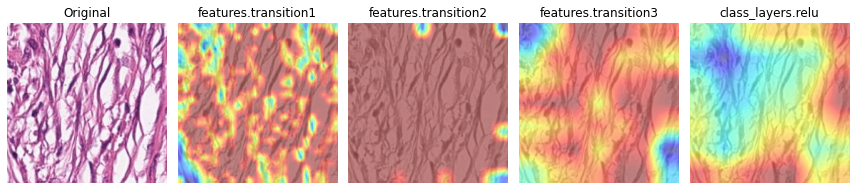

Prediction: 5 (MUS) | Real Label: 7 (STR)


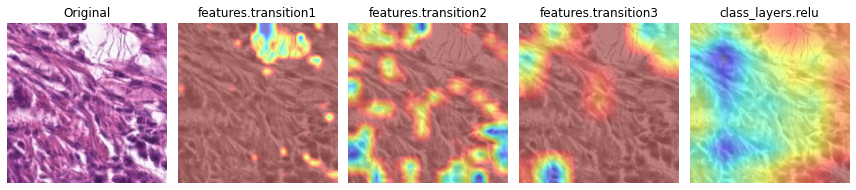

Prediction: 7 (STR) | Real Label: 7 (STR)


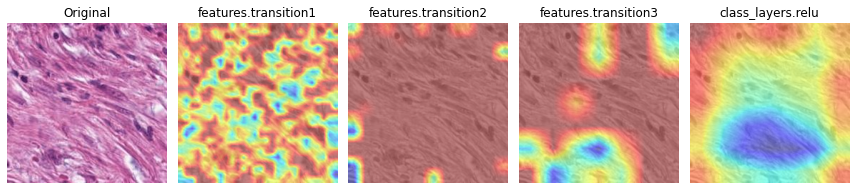

Prediction: 7 (STR) | Real Label: 7 (STR)


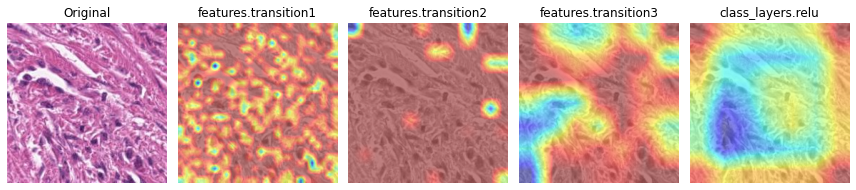

In [142]:
str_label = 7 # STR
mus_label = 5 # MUS

# Get 5 wrong predictions for the STR class
wrong_preds = []
for i in range(len(y_true)):
    if y_true[i] == str_label and y_pred[i] == mus_label:
        wrong_preds.append(i)
    if len(wrong_preds) == 5:
        break

# Plot GradCAM++ and CAM for the wrong predictions
for i in wrong_preds:
    image = image_files_list[i]
    label = y_true[i]

    plot_gradcampp(image, label)